In [2]:
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
def dice_coefficient(y_true, y_pred):
    smooth = 1.0  # to avoid division by zero
    y_true_f = tf.keras.backend.cast(tf.keras.backend.flatten(y_true), 'float32')
    y_pred_f = tf.keras.backend.cast(tf.keras.backend.flatten(y_pred), 'float32')
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    y_true_f = tf.keras.backend.cast(tf.keras.backend.flatten(y_true), 'float32')
    y_pred_f = tf.keras.backend.cast(tf.keras.backend.flatten(y_pred), 'float32')
    intersection = tf.keras.backend.sum(y_true_f*y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f)+tf.keras.backend.sum(y_pred_f)+smooth)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return dice + bce
    


In [3]:
import numpy as np
X_train = np.load('X_train_new.npy')
Y_train = np.load('Y_train_new.npy')
X_val = np.load('val_original_new.npy')
Y_val = np.load('val_masks_new.npy')
X_test = np.load('test_original_new.npy')
Y_test = np.load('test_masks_new.npy')

# Attention

In [2]:
from tensorflow.keras.models import load_model

model = load_model("attention.keras", compile=False, custom_objects={
    "dice_coefficient": dice_coefficient,
    "dice_loss": dice_loss,
    "combined_loss": combined_loss
})
model.compile(optimizer=Adam(learning_rate = 1e-4), loss=combined_loss, metrics=['accuracy', dice_coefficient])


15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
IoU: 0.7367711349296079
Accuracy: 0.8757296752929687
Dice Coefficient: 0.8484377936871568
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8782 - dice_coefficient: 0.8241 - loss: 0.5008
Test Loss: 0.5072090029716492


C:\Users\Diksha\AppData\Roaming\Python\Python312\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


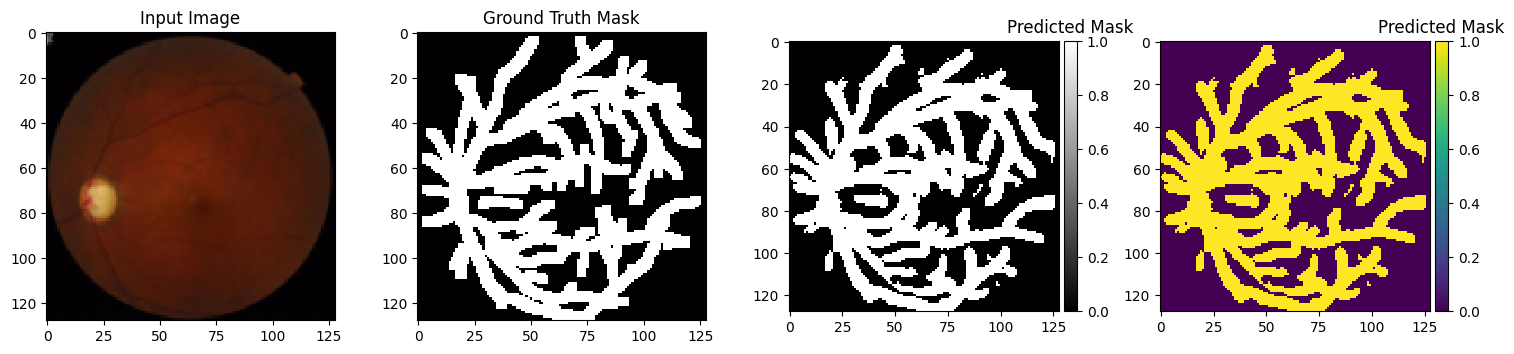

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score, accuracy_score, f1_score
from skimage.io import imshow

# Assuming preds_test_t contains the thresholded predictions and Y_test contains the ground truth masks
# Flatten the arrays for evaluation metrics

preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

Y_test_flat = Y_test.flatten()
preds_test_flat = preds_test_t.flatten()

# Intersection over Union (IoU)
iou = jaccard_score(Y_test_flat, preds_test_flat, average='binary')
print(f"IoU: {iou}")

# Accuracy
accuracy = accuracy_score(Y_test_flat, preds_test_flat)
print(f"Accuracy: {accuracy}")

# Dice Coefficient
dice = f1_score(Y_test_flat, preds_test_flat, average='binary') # manually computed
print(f"Dice Coefficient: {dice}")

# loss
losses = model.evaluate(X_test, Y_test, verbose=1) # The model's built-in Dice score is computed per batch and then averaged.
print(f"Test Loss: {losses[0]}")  # Loss is always the first value


# Visualize some results
sample_indices = np.random.choice(len(Y_test), size=1, replace=False)
for idx in sample_indices:
    plt.figure(figsize=(15, 5))
    
    # Plot the input image
    plt.subplot(1, 4, 1)
    imshow(X_test[idx])
    plt.title("Input Image")
    
    # Plot the ground truth mask
    plt.subplot(1, 4, 2)
    imshow(np.squeeze(Y_test[idx]), cmap='gray')
    plt.title("Ground Truth Mask")
    
    # Plot the predicted mask
    plt.subplot(1, 4, 3)
    imshow(np.squeeze(preds_test_t[idx]), cmap='gray')
    plt.title("Predicted Mask")

    plt.subplot(1, 4, 4)
    imshow(np.squeeze(preds_test_t[idx]))
    plt.title("Predicted Mask")
    
    plt.show()


# unet++

In [16]:
from tensorflow.keras.models import load_model

model = load_model("unet++.keras", compile=False, custom_objects={
    "dice_coefficient": dice_coefficient,
    "dice_loss": dice_loss,
    "combined_loss": combined_loss
})
model.compile(optimizer=Adam(learning_rate = 1e-4), loss=combined_loss, metrics=['accuracy', dice_coefficient])


15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step
IoU: 0.7365090073757925
Accuracy: 0.8758041381835937
Dice Coefficient: 0.8482639643646914
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8779 - dice_coefficient: 0.8216 - loss: 0.4851
Test Loss: 0.49171218276023865


C:\Users\Diksha\AppData\Roaming\Python\Python312\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


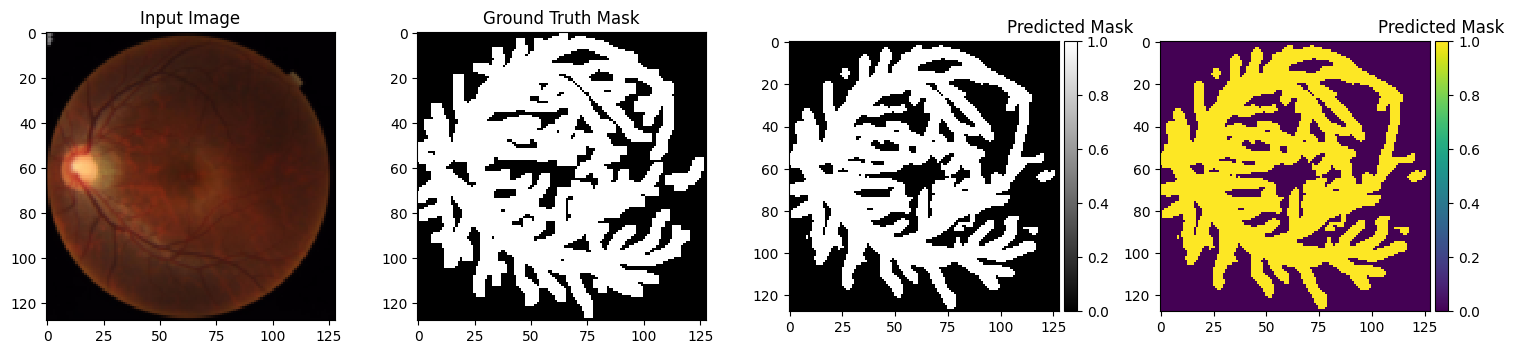

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score, accuracy_score, f1_score
from skimage.io import imshow

# Assuming preds_test_t contains the thresholded predictions and Y_test contains the ground truth masks
# Flatten the arrays for evaluation metrics

preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

Y_test_flat = Y_test.flatten()
preds_test_flat = preds_test_t.flatten()

# Intersection over Union (IoU)
iou = jaccard_score(Y_test_flat, preds_test_flat, average='binary')
print(f"IoU: {iou}")

# Accuracy
accuracy = accuracy_score(Y_test_flat, preds_test_flat)
print(f"Accuracy: {accuracy}")

# Dice Coefficient
dice = f1_score(Y_test_flat, preds_test_flat, average='binary') # manually computed
print(f"Dice Coefficient: {dice}")

# loss
losses = model.evaluate(X_test, Y_test, verbose=1) # The model's built-in Dice score is computed per batch and then averaged.
print(f"Test Loss: {losses[0]}")  # Loss is always the first value


# Visualize some results
sample_indices = np.random.choice(len(Y_test), size=1, replace=False)
for idx in sample_indices:
    plt.figure(figsize=(15, 5))
    
    # Plot the input image
    plt.subplot(1, 4, 1)
    imshow(X_test[idx])
    plt.title("Input Image")
    
    # Plot the ground truth mask
    plt.subplot(1, 4, 2)
    imshow(np.squeeze(Y_test[idx]), cmap='gray')
    plt.title("Ground Truth Mask")
    
    # Plot the predicted mask
    plt.subplot(1, 4, 3)
    imshow(np.squeeze(preds_test_t[idx]), cmap='gray')
    plt.title("Predicted Mask")

    plt.subplot(1, 4, 4)
    imshow(np.squeeze(preds_test_t[idx]))
    plt.title("Predicted Mask")
    
    plt.show()


# unet

In [4]:
from tensorflow.keras.models import load_model

model = load_model("unet.keras", compile=False, custom_objects={
    "dice_coefficient": dice_coefficient,
    "dice_loss": dice_loss,
    "combined_loss": combined_loss
})
model.compile(optimizer=Adam(learning_rate = 1e-4), loss=combined_loss, metrics=['accuracy', dice_coefficient])


15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 983ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
IoU: 0.7401967659975649
Accuracy: 0.8762075805664062
Dice Coefficient: 0.8507046794484167
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8784 - dice_coefficient: 0.8254 - loss: 0.4885
Test Loss: 0.4961455166339874


C:\Users\Diksha\AppData\Roaming\Python\Python312\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


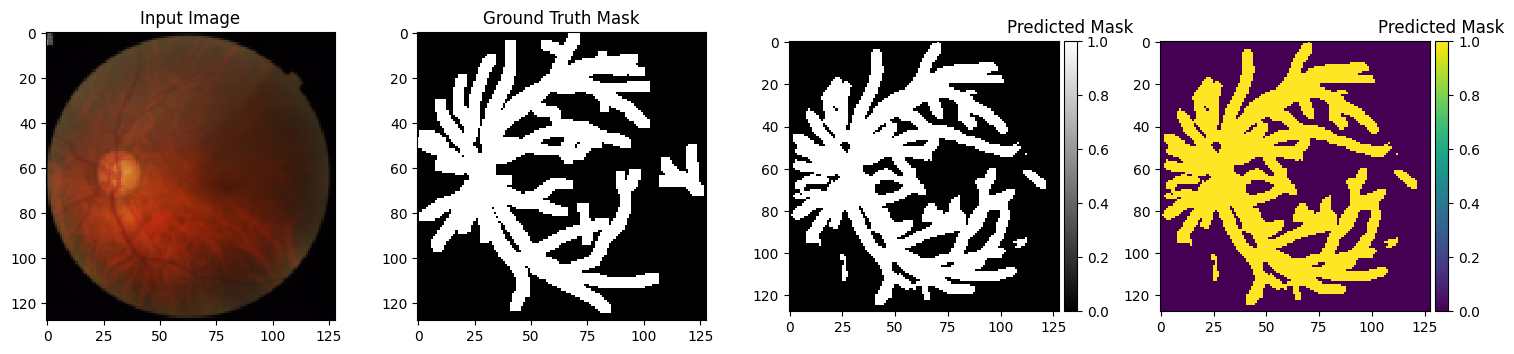

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score, accuracy_score, f1_score
from skimage.io import imshow

# Assuming preds_test_t contains the thresholded predictions and Y_test contains the ground truth masks
# Flatten the arrays for evaluation metrics

preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

Y_test_flat = Y_test.flatten()
preds_test_flat = preds_test_t.flatten()

# Intersection over Union (IoU)
iou = jaccard_score(Y_test_flat, preds_test_flat, average='binary')
print(f"IoU: {iou}")

# Accuracy
accuracy = accuracy_score(Y_test_flat, preds_test_flat)
print(f"Accuracy: {accuracy}")

# Dice Coefficient
dice = f1_score(Y_test_flat, preds_test_flat, average='binary') # manually computed
print(f"Dice Coefficient: {dice}")

# loss
losses = model.evaluate(X_test, Y_test, verbose=1) # The model's built-in Dice score is computed per batch and then averaged.
print(f"Test Loss: {losses[0]}")  # Loss is always the first value


# Visualize some results
sample_indices = np.random.choice(len(Y_test), size=1, replace=False)
for idx in sample_indices:
    plt.figure(figsize=(15, 5))
    
    # Plot the input image
    plt.subplot(1, 4, 1)
    imshow(X_test[idx])
    plt.title("Input Image")
    
    # Plot the ground truth mask
    plt.subplot(1, 4, 2)
    imshow(np.squeeze(Y_test[idx]), cmap='gray')
    plt.title("Ground Truth Mask")
    
    # Plot the predicted mask
    plt.subplot(1, 4, 3)
    imshow(np.squeeze(preds_test_t[idx]), cmap='gray')
    plt.title("Predicted Mask")

    plt.subplot(1, 4, 4)
    imshow(np.squeeze(preds_test_t[idx]))
    plt.title("Predicted Mask")
    
    plt.show()
